In [1]:
import pandas as pd
import os

### 1. Read different datasets

In [22]:
data_folder = "../cleaned_data/german_grid_history"

df = pd.read_pickle(f"{data_folder}/germany_power_mw_2010_2023_public.xz")
df_capa = pd.read_pickle(f"{data_folder}/germany_installed_power_GW_2002_2024.xz")*1000
scenario_table1 = pd.read_csv("../data_collection/cleaned_data/grid_development_scenarios/power_generation_all_sources_Installed power [GW].csv",sep=";")
scenario_table2 = pd.read_csv("../data_collection/cleaned_data/grid_development_scenarios/power_generation_renewables_generation[TWh].csv",sep=";")
the_scenario = "Scenario A 2045"

### 2.Get Energy production[TWh] per installed capacity[GW]

In [27]:
scenario_GW = scenario_table1.set_index("Energy source")[the_scenario]
scenario_twh = scenario_table2.set_index("Erzeugung [TWh]")[the_scenario]

#### 2.1. Renewables

In [36]:
core_renew = ["Solar", "Wind offshore", "Wind onshore"]

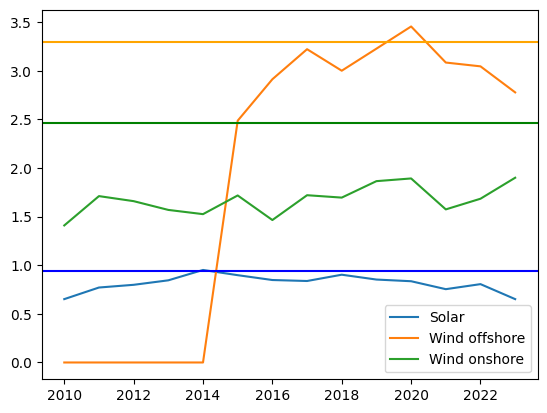

In [37]:
annual_max = df.resample("15min").interpolate().groupby(pd.Grouper(freq="1y")).sum()/4e3 ## Resampling needed for sum as 2010-14 are sampled hourly
annual_max.index = annual_max.index.year
ax = annual_max.divide(df_capa)[core_renew].plot.line()
for renewable_type, color in zip(core_renew, ["blue", "orange", "green"]):
    ax.axhline(scenario_twh[renewable_type] / scenario_GW[renewable_type], color=color)

##### The expectations of the Net development plan are rarely met. Real figures are often below the target, indicating that much more renewable capacity needs to be installed. Let's understand how much more GWs need to be installed additionally

Text(0.5, 1.0, 'Additional renewable capacity needed as less GW are converted into TWh')

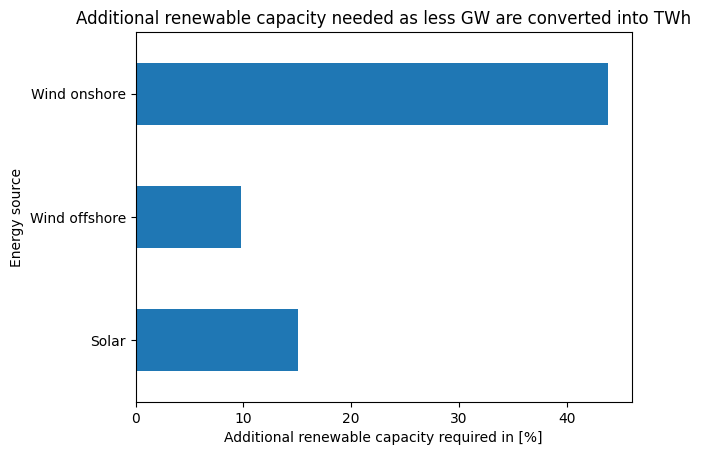

In [56]:
measured_twh_per_GW = annual_max.divide(df_capa)[core_renew]
for col in measured_twh_per_GW.columns:
    measured_twh_per_GW[col] = (scenario_twh[col] / scenario_GW[col]) / measured_twh_per_GW[col] - 1
ax = (measured_twh_per_GW.loc["2015":].mean()*100).plot.barh()
ax.set_xlabel("Additional renewable capacity required in [%]")
ax.set_ylabel("Energy source")
ax.set_title("Additional renewable capacity needed as less GW are converted into TWh")

##### One of the challenges in these calculations is that during fast capacity scaling - the end of year capacity does not reflect the capacity available during the year and hence dividing by the end of year capacity might be misleading. Let's see if this correction changes the numbers significantly. The data source to resolve this issue is the Market Master Data repository.

### 2.2 Solar correction

In [57]:
df_solar = pd.read_pickle(f"../data_collection/cleaned_data/market_master_data/EinheitenSolar.xz")

In [58]:
capa_mastr = df_solar[["Inbetriebnahmedatum", "Bruttoleistung"]].groupby(pd.Grouper(key="Inbetriebnahmedatum", freq="1d")).sum()/1e6

In [62]:
solar_correction = scenario_GW["Solar"] / capa_mastr.cumsum().loc["2010":].resample("15min").ffill()

In [63]:
production_at_2045_GW = df.Solar.resample("15min").interpolate().multiply(solar_correction.T).T

<Axes: >

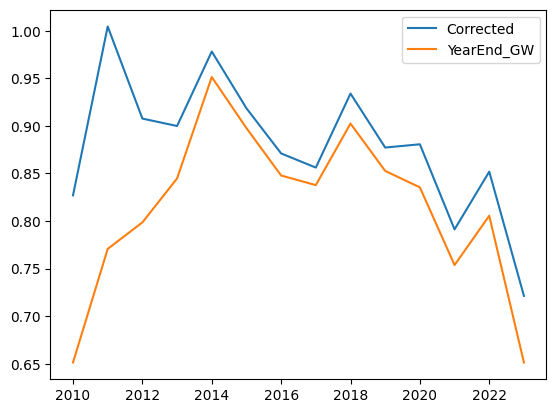

In [73]:
energy_at_2045_TWh = (production_at_2045.groupby(pd.Grouper(freq="1y")).sum()/4e6).iloc[:-1,:]

comparison = (energy_at_2045_TWh/scenario_GW["Solar"]).rename(columns={"Bruttoleistung": "Corrected"})
comparison.index = comparison.index.year
comparison["YearEnd_GW"] = annual_max.divide(df_capa)["Solar"]

comparison.plot.line()

### 2.3 Wind correction

In [74]:
df_wind = pd.read_pickle(f"../data_collection/cleaned_data/market_master_data/EinheitenWind.xz")

In [236]:
df_wind.AuflagenAbschaltungSchallimmissionsschutzNachts.value_counts()

AuflagenAbschaltungSchallimmissionsschutzNachts
0.0    7032
1.0    6444
Name: count, dtype: int64

In [244]:
df_wind.columns

Index(['EinheitMastrNummer', 'DatumLetzteAktualisierung',
       'LokationMaStRNummer', 'NetzbetreiberpruefungStatus',
       'AnlagenbetreiberMastrNummer', 'Land', 'Bundesland', 'Landkreis',
       'Gemeinde', 'Gemeindeschluessel', 'Postleitzahl', 'Gemarkung',
       'FlurFlurstuecknummern', 'StrasseNichtGefunden', 'Hausnummer_nv',
       'HausnummerNichtGefunden', 'Ort', 'Laengengrad', 'Breitengrad',
       'Registrierungsdatum', 'Inbetriebnahmedatum', 'EinheitSystemstatus',
       'EinheitBetriebsstatus', 'NichtVorhandenInMigriertenEinheiten',
       'NameStromerzeugungseinheit', 'Weic_nv', 'Kraftwerksnummer_nv',
       'Energietraeger', 'Bruttoleistung', 'Nettonennleistung',
       'AnschlussAnHoechstOderHochSpannung', 'FernsteuerbarkeitNb',
       'FernsteuerbarkeitDv', 'Einspeisungsart', 'GenMastrNummer',
       'NameWindpark', 'Lage', 'Hersteller', 'Technologie', 'Typenbezeichnung',
       'Nabenhoehe', 'Rotordurchmesser', 'Rotorblattenteisungssystem',
       'AuflageAbschaltung

<Axes: xlabel='Inbetriebnahmedatum'>

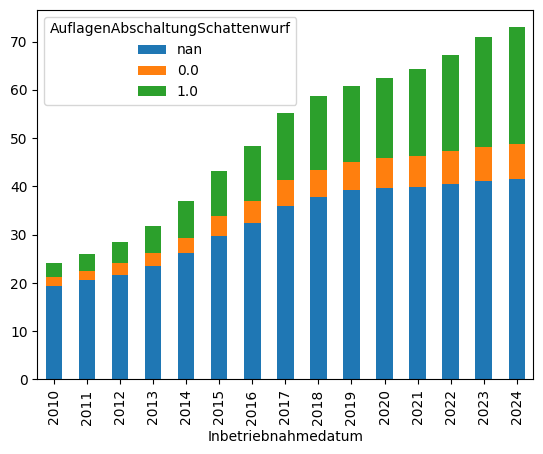

In [247]:
leistung_auflagen = (df_wind[["Inbetriebnahmedatum", "AuflagenAbschaltungSchattenwurf", "Bruttoleistung"]].groupby([pd.Grouper(key="Inbetriebnahmedatum", freq="1y"), "AuflagenAbschaltungSchattenwurf"], dropna=False).sum()/1e6)
leistung_auflagen = leistung_auflagen.unstack().cumsum().droplevel(0, axis=1)
leistung_auflagen.index = leistung_auflagen.index.year
leistung_auflagen.loc["2010":].plot.bar(stacked=True)

In [78]:
df_wind.Seelage.value_counts()

Seelage
Nordsee    1476
Ostsee      308
Name: count, dtype: int64

In [77]:
wind_on_mastr = df_wind[df_wind.Seelage.isna()][["Inbetriebnahmedatum", "Bruttoleistung"]].groupby(pd.Grouper(key="Inbetriebnahmedatum", freq="1d")).sum()/1e6
wind_off_mastr = df_wind[~df_wind.Seelage.isna()][["Inbetriebnahmedatum", "Bruttoleistung"]].groupby(pd.Grouper(key="Inbetriebnahmedatum", freq="1d")).sum()/1e6

<Axes: >

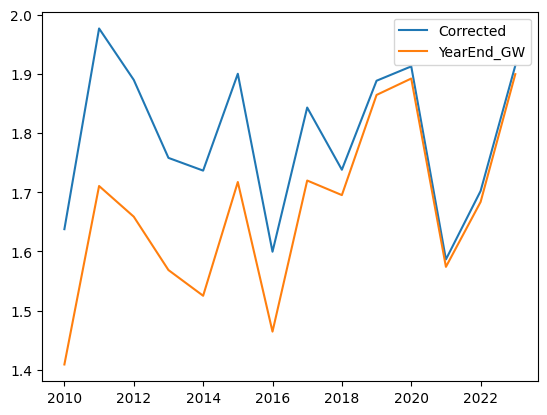

In [86]:
wind_on_correction = scenario_GW["Wind onshore"]/ wind_on_mastr.cumsum().loc["2010":].resample("15min").ffill()
production_at_2045_wind_on = df["Wind onshore"].resample("15min").interpolate().multiply(wind_on_correction.T).T
energy_at_2045_TWh_wind_on = (production_at_2045_wind_on.groupby(pd.Grouper(freq="1y")).sum()/4e6).iloc[:-1,:]

comparison = (energy_at_2045_TWh_wind_on/scenario_GW["Wind onshore"]).rename(columns={"Bruttoleistung": "Corrected"})
comparison.index = comparison.index.year
comparison["YearEnd_GW"] = annual_max.divide(df_capa)["Wind onshore"]

comparison.plot.line()


In [81]:
wind_off_correction = scenario_GW["Wind offshore"]/ wind_off_mastr.cumsum().loc["2010":].resample("15min").ffill()

In [83]:
production_at_2045_wind_off = df["Wind offshore"].resample("15min").interpolate().multiply(wind_off_correction.T).T

<Axes: >

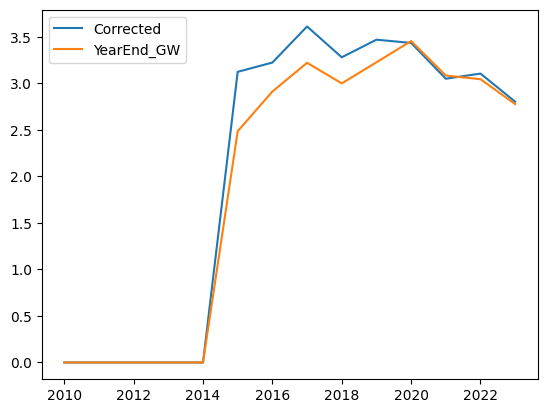

In [84]:
energy_at_2045_TWh_wind_off = (production_at_2045_wind_off.groupby(pd.Grouper(freq="1y")).sum()/4e6).iloc[:-1,:]

comparison = (energy_at_2045_TWh_wind_off/scenario_GW["Wind offshore"]).rename(columns={"Bruttoleistung": "Corrected"})
comparison.index = comparison.index.year
comparison["YearEnd_GW"] = annual_max.divide(df_capa)["Wind offshore"]

comparison.plot.line()

In [119]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def q95(x):
    return x.quantile(0.95)

<Axes: >

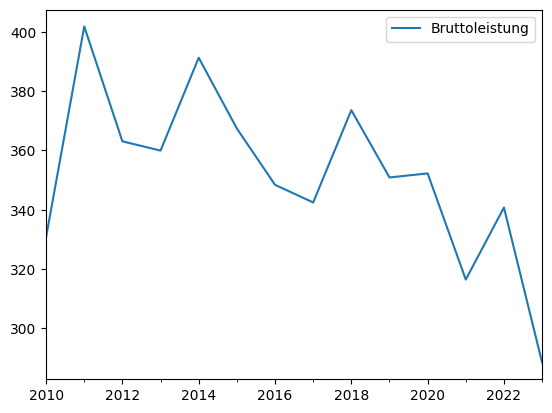

In [124]:
(production_at_2045.groupby(pd.Grouper(freq="1y")).sum()/4e6).iloc[:-1,:].plot.line()

##### Even with correction the current targets for renewable capacity are likely off by >20% and even worse for Onshore Wind > 50%


In [142]:
leistung_einspeisung = (df_solar[["Inbetriebnahmedatum", "Einspeisungsart", "Bruttoleistung"]].groupby([pd.Grouper(key="Inbetriebnahmedatum", freq="1y"), "Einspeisungsart"]).sum()/1e6)
leistung_einspeisung

Bruttoleistung
Inbetriebnahmedatum Einspeisungsart                                                
1900-12-31          Volleinspeisung                                        0.000024
                    Teileinspeisung (einschließlich Eigenverbrauch)        0.000011
1901-12-31          Volleinspeisung                                        0.000000
                    Teileinspeisung (einschließlich Eigenverbrauch)        0.000000
1902-12-31          Volleinspeisung                                        0.000000
...                                                                             ...
2022-12-31          Teileinspeisung (einschließlich Eigenverbrauch)        4.496297
2023-12-31          Volleinspeisung                                        4.968394
                    Teileinspeisung (einschließlich Eigenverbrauch)       10.265512
2024-12-31          Volleinspeisung                                        3.724997
                    Teileinspeisung (einschließlich Eigenverbrauch)        5.137979

[250 rows x 1 columns]

<Axes: xlabel='Inbetriebnahmedatum'>

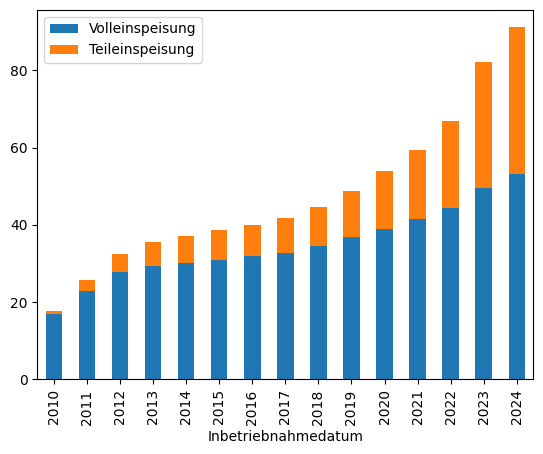

In [143]:
leistung_einspeisung = leistung_einspeisung.unstack().cumsum()
leistung_einspeisung.index = leistung_einspeisung.index.year
leistung_einspeisung.columns = ["Volleinspeisung", "Teileinspeisung"]
leistung_einspeisung.loc["2010":].plot.bar(stacked=True)

In [145]:
df_solar.columns

Index(['EinheitMastrNummer', 'DatumLetzteAktualisierung',
       'LokationMaStRNummer', 'NetzbetreiberpruefungStatus',
       'AnlagenbetreiberMastrNummer', 'Land', 'Bundesland', 'Landkreis',
       'Gemeinde', 'Gemeindeschluessel', 'Postleitzahl', 'Ort',
       'Registrierungsdatum', 'Inbetriebnahmedatum', 'EinheitSystemstatus',
       'EinheitBetriebsstatus', 'NichtVorhandenInMigriertenEinheiten',
       'NameStromerzeugungseinheit', 'Weic_nv', 'Kraftwerksnummer_nv',
       'Energietraeger', 'Bruttoleistung', 'Nettonennleistung',
       'FernsteuerbarkeitNb', 'Einspeisungsart',
       'ZugeordneteWirkleistungWechselrichter', 'AnzahlModule', 'Lage',
       'Leistungsbegrenzung', 'EinheitlicheAusrichtungUndNeigungswinkel',
       'Hauptausrichtung', 'HauptausrichtungNeigungswinkel', 'Nutzungsbereich',
       'EegMaStRNummer', 'Nebenausrichtung', 'NebenausrichtungNeigungswinkel',
       'Strasse', 'StrasseNichtGefunden', 'Hausnummer_nv',
       'HausnummerNichtGefunden', 'Laengengrad', 

In [146]:
leistung_neigung = (df_solar[["Inbetriebnahmedatum", "HauptausrichtungNeigungswinkel", "Bruttoleistung"]].groupby([pd.Grouper(key="Inbetriebnahmedatum", freq="1y"), "HauptausrichtungNeigungswinkel"]).sum()/1e6)
leistung_neigung

Bruttoleistung
Inbetriebnahmedatum HauptausrichtungNeigungswinkel                
1900-12-31          Fassadenintegriert                    0.000003
                    > 60 Grad                             0.000000
                    40 - 60 Grad                          0.000016
                    20 - 40 Grad                          0.000017
                    < 20 Grad                             0.000009
...                                                            ...
2024-12-31          > 60 Grad                             0.021907
                    40 - 60 Grad                          0.794318
                    20 - 40 Grad                          2.853582
                    < 20 Grad                             4.597637
                    Nachgeführt                           0.014768

[750 rows x 1 columns]

<Axes: xlabel='Inbetriebnahmedatum'>

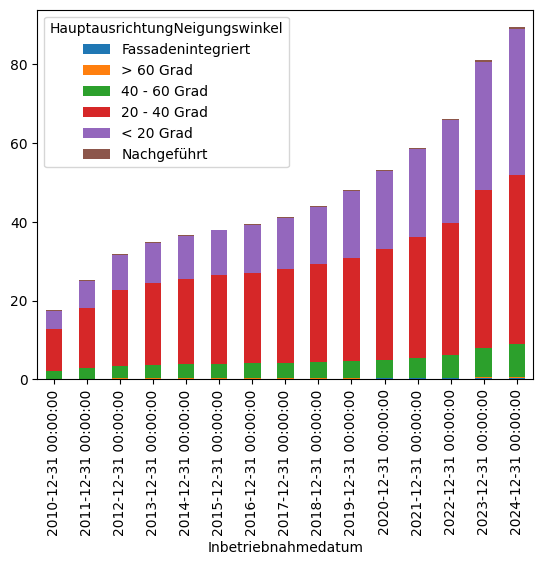

In [152]:
leistung_neigung.unstack().cumsum().droplevel(0, axis=1).loc["2010":].plot.bar(stacked=True)

In [153]:
leistung_ausrichtung = (df_solar[["Inbetriebnahmedatum", "Hauptausrichtung", "Bruttoleistung"]].groupby([pd.Grouper(key="Inbetriebnahmedatum", freq="1y"), "Hauptausrichtung"]).sum()/1e6)
leistung_ausrichtung

Bruttoleistung
Inbetriebnahmedatum Hauptausrichtung                
1900-12-31          Nord                    0.000000
                    Nord-Ost                0.000000
                    Ost                     0.000009
                    Süd-Ost                 0.000013
                    Süd                     0.000021
...                                              ...
2024-12-31          Süd-West                0.874749
                    West                    0.407547
                    Nord-West               0.073948
                    nachgeführt             0.012917
                    Ost-West                1.934914

[1250 rows x 1 columns]

<Axes: xlabel='Inbetriebnahmedatum'>

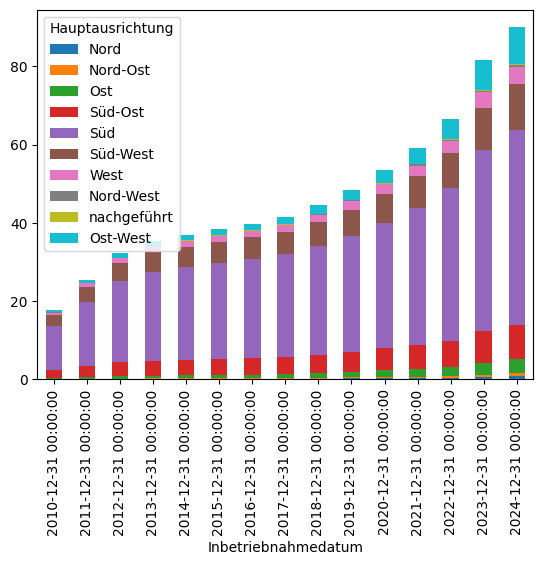

In [154]:
leistung_ausrichtung.unstack().cumsum().droplevel(0, axis=1).loc["2010":].plot.bar(stacked=True)

In [225]:
df_solar["uncontrolled"] = ((df_solar.FernsteuerbarkeitDv != 1))*((df_solar.FernsteuerbarkeitNb != 1))

In [226]:
leistung_breitengrad = (df_solar[["Inbetriebnahmedatum", "uncontrolled", "Bruttoleistung"]].groupby([pd.Grouper(key="Inbetriebnahmedatum", freq="1y"), "uncontrolled"],dropna=False).sum()/1e6)
leistung_breitengrad

Bruttoleistung
Inbetriebnahmedatum uncontrolled                
1900-12-31          True                0.000046
1906-12-31          True                0.000006
1907-12-31          True                0.000012
1908-12-31          True                0.000006
1909-12-31          False               0.000031
...                                          ...
2022-12-31          True                2.939177
2023-12-31          False               7.013739
                    True                8.220187
2024-12-31          False               4.505386
                    True                4.357592

[183 rows x 1 columns]

<Axes: xlabel='Inbetriebnahmedatum'>

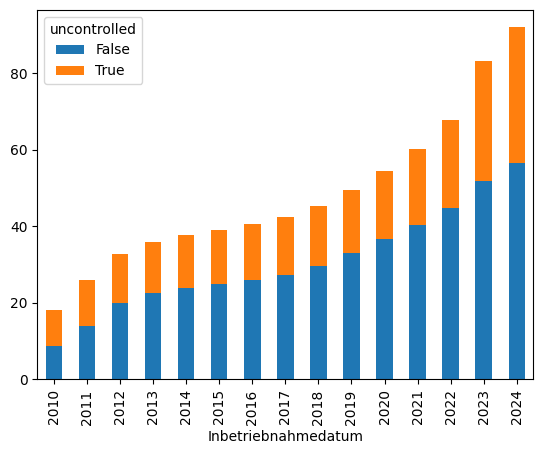

In [228]:
breitengrad_dev = leistung_breitengrad.unstack().cumsum().droplevel(0, axis=1)
#breitengrad_dev = breitengrad_dev.divide(breitengrad_dev.sum(axis=1), axis=0)
breitengrad_dev.index = breitengrad_dev.index.year
breitengrad_dev.loc["2010":].plot.bar(stacked=True)

### 3. Renewable power generation gap - Residual load in the future

#### 3.1. Find max energy demand in 2045

In [87]:
demand_twh = pd.read_csv("../data_collection/cleaned_data/grid_development_scenarios/energy_consumption_Net and Gross energy demand [TWh]_-.csv", sep=";")

In [88]:
demand_twh

,Energy source,Category,Subcategory,Subsubcategory,As-is 2020/21,Scenario A 2037,Scenario B 2037,Scenario C 2037,Scenario A 2045,Scenario B 2045,Scenario C 2045
0,net energy demand,energy_consumption,Net and Gross energy demand [TWh],empty,478.0,828.0,891.0,982.0,999.0,1025.0,1222.0
1,gross energy demand,energy_consumption,Net and Gross energy demand [TWh],empty,533.0,899.0,961.0,1053.0,1079.0,1106.0,1303.0


In [95]:
max_twh_2045 = demand_twh.set_index("Energy source").loc["net energy demand"][the_scenario]
max_twh_2045

999.0

### 3.2. Extrapolate Residual load for 2045 

In [96]:
df["Renewables"] = df.Load - df["Residual load"]

In [97]:
df_forecast = pd.DataFrame({f"old_{col}":df[col].resample("15min").interpolate() for col in ["Load", "Renewables", "Solar", "Wind onshore", "Wind offshore"] })

In [98]:
df_forecast.columns

Index(['old_Load', 'old_Renewables', 'old_Solar', 'old_Wind onshore',
       'old_Wind offshore'],
      dtype='object')

In [99]:
df_forecast["Solar"] = production_at_2045
df_forecast["Wind onshore"] = production_at_2045_wind_on
df_forecast["Wind offshore"] = production_at_2045_wind_off

In [100]:
df_forecast["Renewables"] = df_forecast.old_Renewables - df_forecast[["old_Solar", "old_Wind onshore", "old_Wind offshore"]].sum(axis=1) + df_forecast[["Solar", "Wind onshore", "Wind offshore"]].sum(axis=1) 

In [103]:
load_correction = max_twh_2045/(df.Load.resample("15min").interpolate().groupby(pd.Grouper(freq="1y")).sum()/4e6)
load_correction.index = load_correction.index.year
load_correction

2010    1.885815
2011    1.898077
2012    1.887077
2013    1.912032
2014    1.951864
2015    1.997123
2016    1.985753
2017    1.975579
2018    1.962068
2019    2.008900
2020    2.058561
2021    1.980116
2022    2.069876
2023    2.179933
Name: Load, dtype: float64

In [104]:
df_forecast["Load"] = df_forecast.old_Load

In [105]:
for year in load_correction.index:
    df_forecast["Load"].loc[f"{year}"] *= load_correction[year] 

<Axes: >

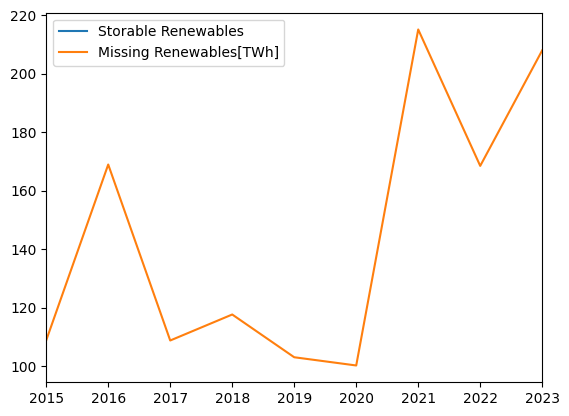

In [112]:
diff = (df_forecast.Renewables - df_forecast.Load)

overview = pd.DataFrame({"Storable Renewables": (diff[diff > 0].groupby(pd.Grouper(freq="1y")).sum()/4e6).loc["2015":],
                         "Missing Renewables[TWh]":-(diff[diff < 0].groupby(pd.Grouper(freq="1y")).sum()/4e6).loc["2015":]})
overview.diff(axis=1).plot.line()

<Axes: >

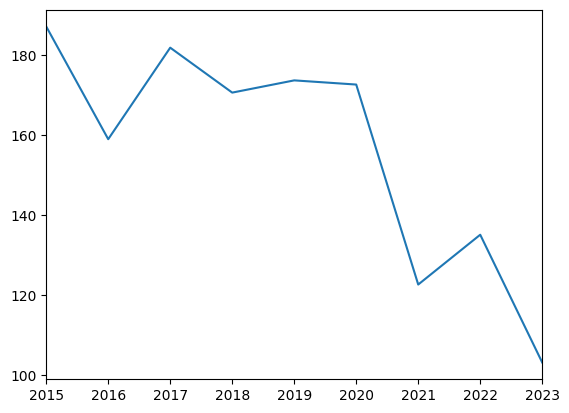

In [108]:
.plot.line()

<Axes: >

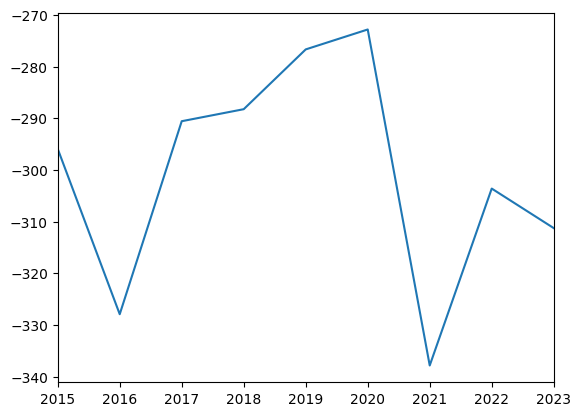

In [178]:
(diff[diff < 0].groupby(pd.Grouper(freq="1y")).sum()/4e6).loc["2015":].plot.line()

In [174]:
df_forecast.Load.groupby(pd.Grouper(freq="1y")).sum()/4e6

2010-12-31    999.0
2011-12-31    999.0
2012-12-31    999.0
2013-12-31    999.0
2014-12-31    999.0
2015-12-31    999.0
2016-12-31    999.0
2017-12-31    999.0
2018-12-31    999.0
2019-12-31    999.0
2020-12-31    999.0
2021-12-31    999.0
2022-12-31    999.0
2023-12-31    999.0
Freq: A-DEC, Name: Load, dtype: float64

In [175]:
df_forecast.Renewables.groupby(pd.Grouper(freq="1y")).sum()/4e6

2010-12-31    621.484615
2011-12-31    743.590250
2012-12-31    697.147574
2013-12-31    674.015165
2014-12-31    698.723136
2015-12-31    890.142170
2016-12-31    830.024084
2017-12-31    890.199882
2018-12-31    881.312671
2019-12-31    895.930262
2020-12-31    898.744634
2021-12-31    783.843806
2022-12-31    830.495552
2023-12-31    790.974362
Freq: A-DEC, Name: Renewables, dtype: float64

In [176]:
df_forecast.head()

,old_Load,old_Renewables,old_Solar,old_Wind onshore,old_Wind offshore,Solar,Wind onshore,Wind offshore,Renewables,Load
2010-01-01 00:00:00,47394.0,7006.0,0.0,3665.00,NaN,0.0,25989.974517,NaN,29330.974517,89376.337280
2010-01-01 00:15:00,47196.5,6972.0,0.0,3656.25,NaN,0.0,25927.924783,NaN,29243.674783,89003.888730
2010-01-01 00:30:00,46999.0,6938.0,0.0,3647.50,NaN,0.0,25865.875048,NaN,29156.375048,88631.440179
2010-01-01 00:45:00,46801.5,6904.0,0.0,3638.75,NaN,0.0,25803.825314,NaN,29069.075314,88258.991628
2010-01-01 01:00:00,46604.0,6870.0,0.0,3630.00,NaN,0.0,25741.775579,NaN,28981.775579,87886.543077


In [298]:
battery_size_needs = [diff.loc["2015":"2023"].resample(f"{hours}d").sum().agg(["min", "max"])/4e6 for hours in range(1, 96)]

<Axes: >

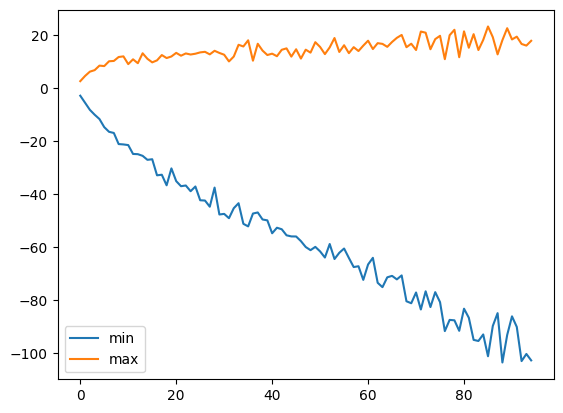

In [301]:
(pd.DataFrame(battery_size_needs)).plot.line()

In [302]:
import_sizes = [df["Import Balance"].loc["2020":"2023"].resample("15min").interpolate().resample(f"{hours}d").sum().agg(["min", "max"])/4e6*4 for hours in range(1, 100)]

<Axes: >

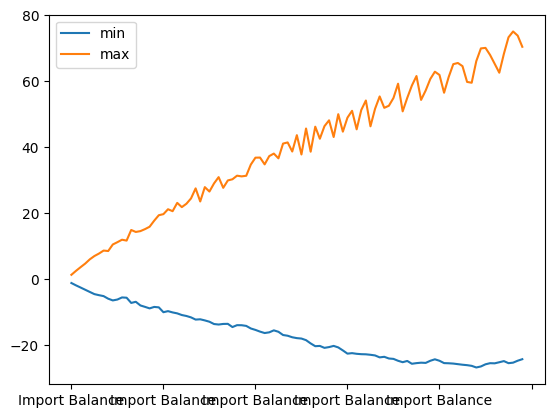

In [303]:
pd.DataFrame(import_sizes).plot.line()

<Axes: >

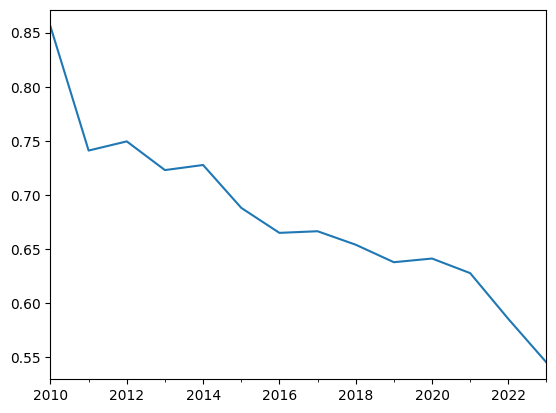

In [216]:
((df_forecast.Solar.resample("15min").interpolate().groupby(pd.Grouper(freq="1y")).max()/1000/solar_2045).plot.line())

<Axes: xlabel='Inbetriebnahmedatum'>

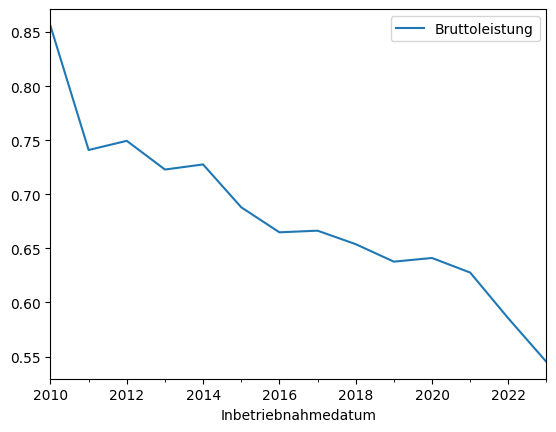

In [249]:
capa_detail = capa_mastr.cumsum().loc["2010":"2023"].resample("15min").ffill()
power_vsmaxcapa = (df.Solar.resample("15min").interpolate()[capa_detail.index] / capa_detail.T).T
(power_vsmaxcapa.groupby(pd.Grouper(freq="1y")).max()/1000).plot.line()

<Axes: >

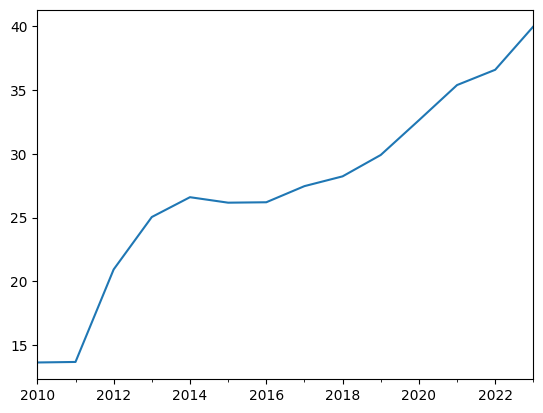

In [252]:
(df.Solar.groupby(pd.Grouper(freq="1y")).max()/1000).plot.line()

<Axes: xlabel='Inbetriebnahmedatum'>

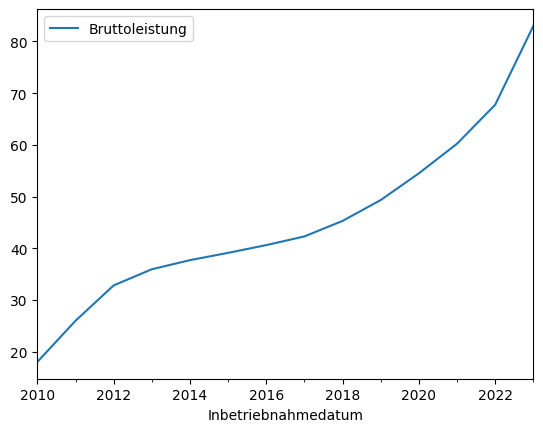

In [253]:
capa_detail.groupby(pd.Grouper(freq="1y")).max().plot.line()

In [293]:
df.resample("15min").interpolate().groupby(pd.Grouper(freq="1y")).sum()

,Biomass,Import Balance,Solar,year,hour,Others,Fossil brown coal / lignite,Fossil gas,Fossil hard coal,Fossil oil,Geothermal,Load,Nuclear,Residual load,Waste,Wind offshore,Wind onshore,Hydro,Renewables
2010-12-31,1.262039e+08,-3.049334e+07,46915708.0,70430401.5,402960.0,0.0,5.217131e+08,252368007.5,398819450.5,5835820.0,0.0,2.118977e+09,5.318837e+08,1.806332e+09,0.0,0.0,151187451.0,114542080.0,312645239.0
2011-12-31,1.380597e+08,-2.811749e+06,78395828.0,70465441.5,402960.0,21056312.0,5.362292e+08,239041393.0,385996492.5,2732124.0,0.0,2.105289e+09,4.089532e+08,1.729257e+09,0.0,0.0,195553293.0,102083280.0,376032401.0
2012-12-31,1.637288e+08,-8.176671e+07,105519872.0,70693633.5,404064.0,24277806.0,5.674607e+08,199472980.0,423317035.5,9325236.5,0.0,2.117561e+09,3.767171e+08,1.682533e+09,0.0,0.0,202745547.5,126762812.5,435028232.0
2013-12-31,1.702941e+08,-1.271801e+08,124039936.0,70535521.5,402960.0,24673142.5,5.804976e+08,158335552.5,442898630.0,9942918.5,0.0,2.089924e+09,3.685135e+08,1.627975e+09,0.0,0.0,206867139.0,131041214.0,461948289.0
2014-12-31,1.797077e+08,-1.305347e+08,144223688.0,70570561.5,402960.0,20047833.5,5.631653e+08,123792745.7,424329030.7,7411510.5,0.0,2.047274e+09,3.671992e+08,1.555123e+09,0.0,0.0,229514698.4,118415602.7,492151755.0
2015-12-31,1.769080e+08,-2.067523e+08,140839997.4,70605600.0,402960.0,9395625.0,5.574846e+08,120492936.1,424830046.3,6991793.1,363994.9,2.000878e+09,3.470600e+08,1.543702e+09,40560225.9,32647996.1,283687996.9,66366792.5,457176009.1
2016-12-31,1.788080e+08,-1.972832e+08,137960000.5,70834176.0,404064.0,10866011.1,5.395423e+08,186012084.1,399059731.1,6957581.0,656008.8,2.012334e+09,3.201526e+08,1.560710e+09,42454299.2,48367997.1,265296001.6,73485038.9,451624008.3
2017-12-31,1.788080e+08,-2.016567e+08,141723976.3,70675680.0,402960.0,19357804.4,5.359330e+08,195825443.3,326894465.6,7062130.7,628004.9,2.022699e+09,2.886199e+08,1.466147e+09,42713195.8,69655988.1,345172008.8,71961353.3,556552016.7
2018-12-31,1.772240e+08,-1.433718e+08,163188809.2,70710720.0,402960.0,14365641.8,5.259903e+08,178132513.1,289624264.7,11188609.3,503996.0,2.036626e+09,2.874658e+08,1.441881e+09,42351133.2,76716003.9,354839998.5,58406965.9,594744811.4
2019-12-31,1.763560e+08,-8.709190e+07,166661509.5,70745760.0,402960.0,13312962.5,4.076976e+08,211598680.1,198010094.3,15887152.6,575999.2,1.989148e+09,2.839687e+08,1.328306e+09,40101015.4,97516003.2,396664005.3,67890098.1,660841517.2


<Axes: >

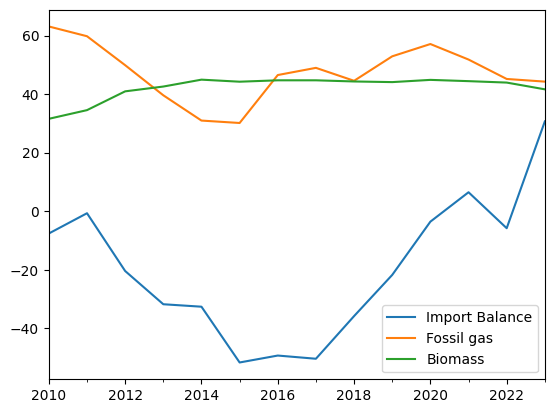

In [251]:
cols = list(df.columns)
df["Import Balance"] = df.Load - df[list(set(cols) - set(["year", "hour", "Import Balance", "Load", "Renewables", "Residual load"]))].sum(axis=1)

In [257]:
df["Solar_ratio"] = (df["Solar"]/df.Load) * df["Import Balance"] 

<Axes: >

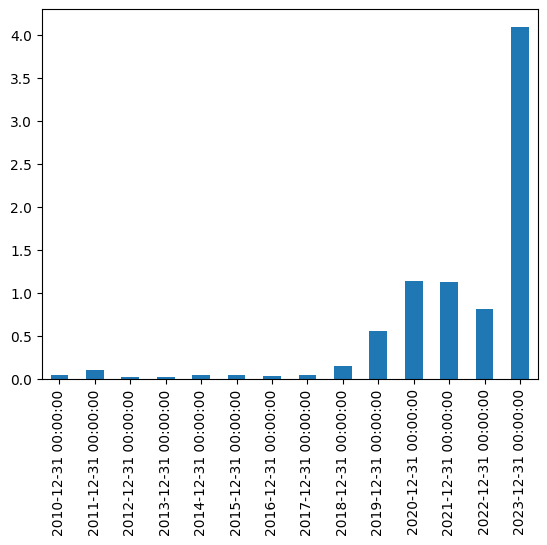

In [261]:
(df.Solar_ratio[df["Solar_ratio"] > 0].groupby(pd.Grouper(freq="1y")).sum()/4e6).plot.bar()